In [37]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output


In [30]:
 df = pd.read_csv("AI_Recipe_Health_Dataset_1200_rows.csv")

print("Shape:", df.shape)
print("Columns:", list(df.columns))
display(df.head())


Shape: (1200, 14)
Columns: ['recipe_id', 'calories', 'protein_g', 'fat_g', 'carbs_g', 'fiber_g', 'sugar_g', 'sodium_mg', 'prep_time_min', 'ingredients_count', 'meal_type', 'diet_type', 'health_score', 'rating']


,recipe_id,calories,protein_g,fat_g,carbs_g,fiber_g,sugar_g,sodium_mg,prep_time_min,ingredients_count,meal_type,diet_type,health_score,rating
0,1,754,8.46,52.17,33.16,3.49,5.12,1566,119,20,Breakfast,Vegan,55,1.1
1,2,195,14.68,35.87,8.05,4.97,32.49,1166,58,10,Snack,Vegan,36,4.2
2,3,106,46.01,12.02,53.60,6.95,10.77,1613,48,6,Breakfast,Non-Veg,13,2.4
3,4,452,37.02,56.69,88.92,13.41,48.66,825,15,20,Dinner,Vegan,80,4.5
4,5,470,35.49,49.62,10.27,5.70,14.47,213,114,10,Breakfast,Non-Veg,36,2.8


Class counts (0=Unhealthy, 1=Healthy):
label
0    571
1    629
Name: count, dtype: int64


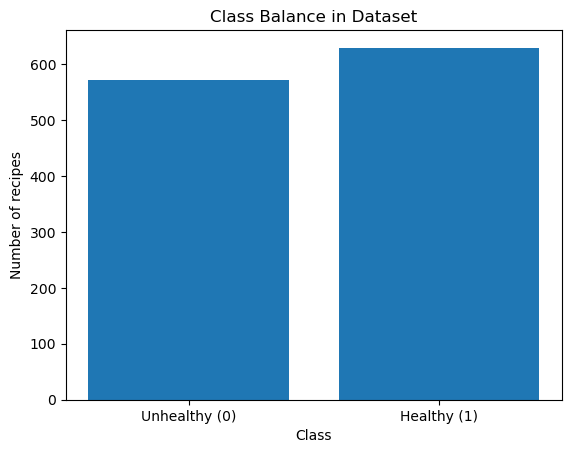

In [31]:
# Healthy if health_score >= 50, else Unhealthy
df["label"] = np.where(df["health_score"] >= 50, 1, 0)  # 1=Healthy, 0=Unhealthy

counts = df["label"].value_counts().sort_index()
print("Class counts (0=Unhealthy, 1=Healthy):")
print(counts)

plt.figure()
plt.bar(["Unhealthy (0)", "Healthy (1)"], [counts[0], counts[1]])
plt.title("Class Balance in Dataset")
plt.xlabel("Class")
plt.ylabel("Number of recipes")
plt.show()


In [32]:
# We will use these features:
num_features = [
    "calories", "protein_g", "fat_g", "carbs_g", "fiber_g", "sugar_g",
    "sodium_mg", "prep_time_min", "ingredients_count", "rating"
]
cat_features = ["meal_type", "diet_type"]

# Keep only required columns (drop recipe_id, health_score)
df_model = df[num_features + cat_features + ["label"]].copy()

X = df_model[num_features + cat_features]
y = df_model["label"]

display(X.head())


,calories,protein_g,fat_g,carbs_g,fiber_g,sugar_g,sodium_mg,prep_time_min,ingredients_count,rating,meal_type,diet_type
0,754,8.46,52.17,33.16,3.49,5.12,1566,119,20,1.1,Breakfast,Vegan
1,195,14.68,35.87,8.05,4.97,32.49,1166,58,10,4.2,Snack,Vegan
2,106,46.01,12.02,53.60,6.95,10.77,1613,48,6,2.4,Breakfast,Non-Veg
3,452,37.02,56.69,88.92,13.41,48.66,825,15,20,4.5,Dinner,Vegan
4,470,35.49,49.62,10.27,5.70,14.47,213,114,10,2.8,Breakfast,Non-Veg


In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)


In [44]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": GaussianNB(),
}

results = []

for name, clf in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", clf)
    ])
    
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    acc = accuracy_score(y_test, preds)
    
    results.append((name, acc))

results_df = pd.DataFrame(results, columns=["Model", "Accuracy"])
display(results_df)


,Model,Accuracy
0,Logistic Regression,0.558333
1,Random Forest,0.512500
2,Naive Bayes,0.508333


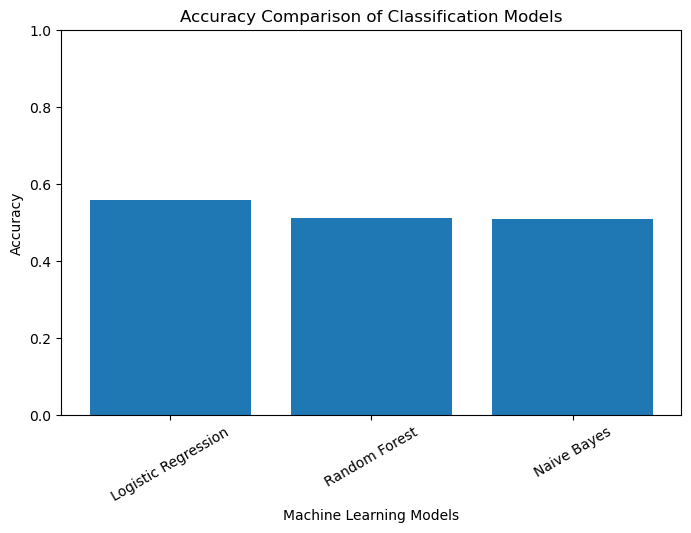

In [45]:
plt.figure(figsize=(8,5))
plt.bar(results_df["Model"], results_df["Accuracy"])
plt.ylim(0,1)
plt.xlabel("Machine Learning Models")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of Classification Models")
plt.xticks(rotation=30)
plt.show()


In [46]:
final_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=2000))
])

final_model.fit(X_train, y_train)

preds = final_model.predict(X_test)
acc = accuracy_score(y_test, preds)

print("Final Model: Logistic Regression")
print("Test Accuracy:", round(acc, 4))
print("\nClassification Report:\n")
print(classification_report(y_test, preds, target_names=["Unhealthy", "Healthy"]))


Final Model: Logistic Regression
Test Accuracy: 0.5583

Classification Report:

              precision    recall  f1-score   support

   Unhealthy       0.55      0.41      0.47       114
     Healthy       0.56      0.69      0.62       126

    accuracy                           0.56       240
   macro avg       0.56      0.55      0.55       240
weighted avg       0.56      0.56      0.55       240



<Figure size 500x500 with 0 Axes>

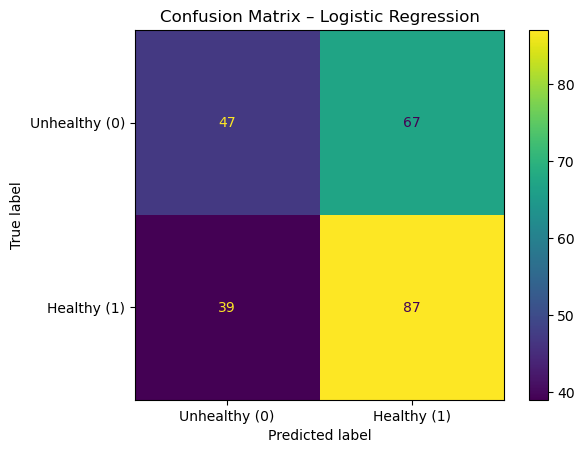

In [47]:
plt.figure(figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(
    y_test, preds,
    display_labels=["Unhealthy (0)", "Healthy (1)"],
    values_format="d"
)
plt.title("Confusion Matrix – Logistic Regression")
plt.show()


In [48]:
# Helper: create labeled fields like your friend's UI
def create_field(label_text, widget):
    label = widgets.HTML(value=f"<b>{label_text}</b>")
    return widgets.VBox([label, widget], layout=widgets.Layout(margin="6px 0"))

# Text inputs for numbers (so they can be empty)
inputs_num = {
    "calories": widgets.Text(placeholder="e.g., 350", layout=widgets.Layout(width="320px")),
    "protein_g": widgets.Text(placeholder="e.g., 12.5", layout=widgets.Layout(width="320px")),
    "fat_g": widgets.Text(placeholder="e.g., 10.0", layout=widgets.Layout(width="320px")),
    "carbs_g": widgets.Text(placeholder="e.g., 40.0", layout=widgets.Layout(width="320px")),
    "fiber_g": widgets.Text(placeholder="e.g., 6.0", layout=widgets.Layout(width="320px")),
    "sugar_g": widgets.Text(placeholder="e.g., 8.0", layout=widgets.Layout(width="320px")),
    "sodium_mg": widgets.Text(placeholder="e.g., 800", layout=widgets.Layout(width="320px")),
    "prep_time_min": widgets.Text(placeholder="e.g., 30", layout=widgets.Layout(width="320px")),
    "ingredients_count": widgets.Text(placeholder="e.g., 10", layout=widgets.Layout(width="320px")),
    "rating": widgets.Text(placeholder="e.g., 3.8", layout=widgets.Layout(width="320px")),
}

meal_opts = sorted(df_model["meal_type"].dropna().unique().tolist())
diet_opts = sorted(df_model["diet_type"].dropna().unique().tolist())

inputs_cat = {
    "meal_type": widgets.Dropdown(options=meal_opts, layout=widgets.Layout(width="320px")),
    "diet_type": widgets.Dropdown(options=diet_opts, layout=widgets.Layout(width="320px")),
}

# For red border highlight
_base_borders = {k: w.layout.border for k, w in inputs_num.items()}

def set_error_border(key):
    inputs_num[key].layout.border = "2px solid #e55353"

def clear_error_borders():
    for k, w in inputs_num.items():
        w.layout.border = _base_borders[k]

def parse_float(name, value, min_val=None):
    value = value.strip()
    if value == "":
        raise ValueError(f"{name} is required")
    v = float(value)
    if min_val is not None and v < min_val:
        raise ValueError(f"{name} must be ≥ {min_val}")
    return v

predict_button = widgets.Button(description="Predict Healthy / Unhealthy", button_style="success")
status_bar = widgets.HTML(value="<b>Ready.</b>")
output_area = widgets.Output()

def on_predict_clicked(_):
    clear_error_borders()
    status_bar.value = "<b>Running prediction…</b>"

    with output_area:
        clear_output()

        # Validate + convert inputs
        errors = []
        casted = {}

        try:
            casted["calories"] = parse_float("calories", inputs_num["calories"].value, 0)
        except Exception as e:
            errors.append(str(e)); set_error_border("calories")

        for k in ["protein_g","fat_g","carbs_g","fiber_g","sugar_g"]:
            try:
                casted[k] = parse_float(k, inputs_num[k].value, 0)
            except Exception as e:
                errors.append(str(e)); set_error_border(k)

        try:
            casted["sodium_mg"] = parse_float("sodium_mg", inputs_num["sodium_mg"].value, 0)
        except Exception as e:
            errors.append(str(e)); set_error_border("sodium_mg")

        try:
            casted["prep_time_min"] = parse_float("prep_time_min", inputs_num["prep_time_min"].value, 0)
        except Exception as e:
            errors.append(str(e)); set_error_border("prep_time_min")

        try:
            casted["ingredients_count"] = int(float(inputs_num["ingredients_count"].value.strip() or ""))
            if casted["ingredients_count"] < 0:
                raise ValueError("ingredients_count must be ≥ 0")
        except Exception:
            errors.append("ingredients_count must be a valid number (e.g., 10)")
            set_error_border("ingredients_count")

        try:
            casted["rating"] = parse_float("rating", inputs_num["rating"].value, 0)
        except Exception as e:
            errors.append(str(e)); set_error_border("rating")

        # Categorical
        casted["meal_type"] = inputs_cat["meal_type"].value
        casted["diet_type"] = inputs_cat["diet_type"].value

        if errors:
            status_bar.value = "<b>⚠️ Fix the highlighted fields.</b>"
            print("Validation issues:")
            for err in errors:
                print(" -", err)
            return

        # Predict
        user_df = pd.DataFrame([casted], columns=num_features + cat_features)

        pred = model.predict(user_df)[0]
        proba = model.predict_proba(user_df)[0]  # [P(Unhealthy), P(Healthy)]

        label = "Healthy ✅" if pred == 1 else "Unhealthy ❌"
        conf = proba[1] if pred == 1 else proba[0]

        print("✅ Prediction Result")
        print("-" * 50)
        print("Prediction:", label)
        print("Confidence:", f"{conf*100:.2f}%")
        print("\nProbability details:")
        print(f"  Unhealthy (0): {proba[0]*100:.2f}%")
        print(f"  Healthy   (1): {proba[1]*100:.2f}%")
        print("\nInput used:")
        display(user_df)

        status_bar.value = "<b>✅ Done.</b>"

predict_button.on_click(on_predict_clicked)

# Layout (nicer, like your friend's)
form_items = []
form_items += [create_field("Calories", inputs_num["calories"])]
form_items += [create_field("Protein (g)", inputs_num["protein_g"])]
form_items += [create_field("Fat (g)", inputs_num["fat_g"])]
form_items += [create_field("Carbs (g)", inputs_num["carbs_g"])]
form_items += [create_field("Fiber (g)", inputs_num["fiber_g"])]
form_items += [create_field("Sugar (g)", inputs_num["sugar_g"])]
form_items += [create_field("Sodium (mg)", inputs_num["sodium_mg"])]
form_items += [create_field("Prep time (minutes)", inputs_num["prep_time_min"])]
form_items += [create_field("Ingredients count", inputs_num["ingredients_count"])]
form_items += [create_field("Rating", inputs_num["rating"])]
form_items += [create_field("Meal type", inputs_cat["meal_type"])]
form_items += [create_field("Diet type", inputs_cat["diet_type"])]

title = widgets.HTML("<h2>Food Healthiness Prediction Application</h2><p>Enter nutrition values and predict if the recipe is Healthy or Unhealthy.</p>")

ui = widgets.VBox(
    [title] + form_items + [predict_button, status_bar, output_area],
    layout=widgets.Layout(width="420px")
)

display(ui)
